In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math
from IPython.display import display
from ipywidgets import FileUpload

Upload Gambar

In [2]:
uploader = FileUpload(accept='image/*', multiple=False)
display(uploader)

FileUpload(value=(), accept='image/*', description='Upload')

Load Gambar dari Upload

Gambar berhasil dimuat!


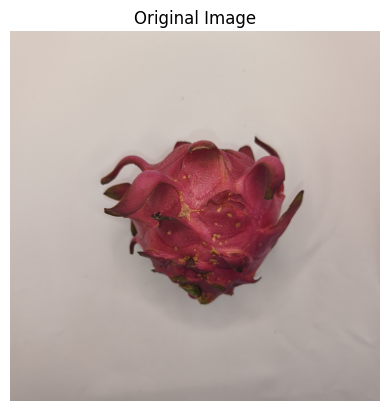

In [6]:
# Load image from uploader (untuk ipywidgets.FileUpload)
uploaded_files = uploader.value

if len(uploaded_files) == 0:
    print("Belum ada file yang di-upload!")
else:
    # Ambil file pertama
    file_info = uploaded_files[0]

    # Ambil konten biner
    content = file_info['content']

    # Konversi ke numpy array
    np_img = np.frombuffer(content, np.uint8)

    # Decode ke gambar OpenCV
    img = cv2.imdecode(np_img, cv2.IMREAD_COLOR)

    print("Gambar berhasil dimuat!")

    # Tampilkan
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title("Original Image")
    plt.axis("off")


## Preprocessing

In [17]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def preprocess_image(img):
    blur = cv2.GaussianBlur(img, (3, 3), 0)
    hsv = cv2.cvtColor(blur, cv2.COLOR_BGR2HSV)
    return blur, hsv

def get_gaussian_kernel_3x3():
    g1d = cv2.getGaussianKernel(3, 0)
    g2d = g1d @ g1d.T
    return g2d

# --- NEW: generate HSV "kernel" visualization ---
def get_hsv_kernel_visualization():
    # pola gradient 3×3 untuk memancing perubahan HSV
    block = np.array([
        [[ 50,  50, 200], [ 80,  80, 220], [110, 110, 240]],
        [[ 50, 200,  50], [ 80, 220,  80], [110, 240,110]],
        [[200,  50,  50], [220,  80,  80], [240,110,110]],
    ], dtype=np.uint8)

    hsv = cv2.cvtColor(block, cv2.COLOR_BGR2HSV)
    
    # Ambil channel Hue saja agar tampil seperti “kernel”
    return hsv[:, :, 0].astype(float)

# --- Process image ---
blur, hsv = preprocess_image(img)
kernel_gaussian = get_gaussian_kernel_3x3()
kernel_hsv = get_hsv_kernel_visualization()


OUTPUT PREPROCESSING

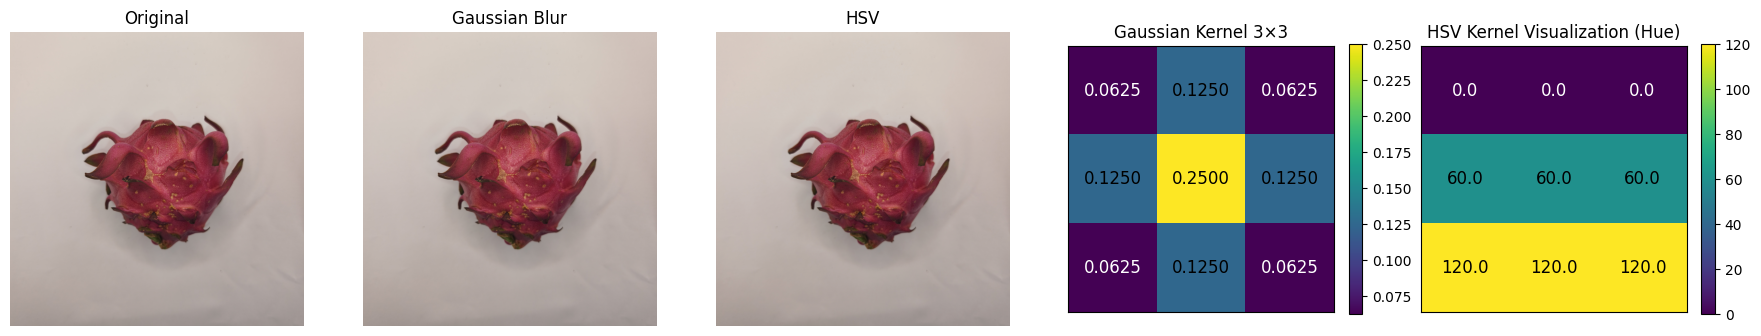

Kernel Gaussian 3×3:
 [[0.0625 0.125  0.0625]
 [0.125  0.25   0.125 ]
 [0.0625 0.125  0.0625]]

HSV Kernel Visualization (Hue channel):
 [[  0.   0.   0.]
 [ 60.  60.  60.]
 [120. 120. 120.]]


In [26]:
fig, axes = plt.subplots(1, 5, figsize=(22, 5))

# --- 1: Original ---
axes[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
axes[0].set_title("Original")
axes[0].axis("off")

# --- 2: Gaussian Blur ---
axes[1].imshow(cv2.cvtColor(blur, cv2.COLOR_BGR2RGB))
axes[1].set_title("Gaussian Blur")
axes[1].axis("off")

# --- 3: HSV ---
axes[2].imshow(cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB))
axes[2].set_title("HSV")
axes[2].axis("off")

# --- 4: Gaussian Kernel Visualization ---
im1 = axes[3].imshow(kernel_gaussian, cmap="viridis")
axes[3].set_title("Gaussian Kernel 3×3")

# Hilangkan sumbu supaya angka kernel tidak mepet
axes[3].set_xticks([])
axes[3].set_yticks([])

# Tambahkan angka kernel
for i in range(kernel_gaussian.shape[0]):
    for j in range(kernel_gaussian.shape[1]):
        val = kernel_gaussian[i, j]
        text_color = "white" if val < (kernel_gaussian.max() * 0.5) else "black"
        axes[3].text(j, i, f"{val:.4f}", ha="center", va="center", color=text_color, fontsize=12)

plt.colorbar(im1, ax=axes[3], fraction=0.046)

# --- 5: HSV Kernel Visualization ---
im2 = axes[4].imshow(kernel_hsv, cmap="viridis")
axes[4].set_title("HSV Kernel Visualization (Hue)")

# Hilangkan sumbu Y & X
axes[4].set_xticks([])
axes[4].set_yticks([])

# Tambahkan nilai kernel HSV
for i in range(kernel_hsv.shape[0]):
    for j in range(kernel_hsv.shape[1]):
        val = kernel_hsv[i, j]
        text_color = "white" if val < (kernel_hsv.max() * 0.5) else "black"
        axes[4].text(j, i, f"{val:.1f}", ha="center", va="center", color=text_color, fontsize=12)

plt.colorbar(im2, ax=axes[4], fraction=0.046)

plt.show()

print("Kernel Gaussian 3×3:\n", kernel_gaussian)
print("\nHSV Kernel Visualization (Hue channel):\n", kernel_hsv)


## Segmentasi

In [27]:
def segment_image(hsv):

    lower_red1 = np.array([0, 40, 40])
    upper_red1 = np.array([15, 255, 255])
    lower_red2 = np.array([160, 40, 40])
    upper_red2 = np.array([180, 255, 255])

    lower_green = np.array([35, 40, 40])
    upper_green = np.array([90, 255, 255])

    lower_yellow = np.array([20, 40, 40])
    upper_yellow = np.array([45, 255, 255])

    mask_red = cv2.bitwise_or(cv2.inRange(hsv, lower_red1, upper_red1),
                              cv2.inRange(hsv, lower_red2, upper_red2))
    mask_green = cv2.inRange(hsv, lower_green, upper_green)
    mask_yellow = cv2.inRange(hsv, lower_yellow, upper_yellow)

    mask = cv2.bitwise_or(mask_red, cv2.bitwise_or(mask_green, mask_yellow))

    bg_light = cv2.inRange(hsv, (0, 0, 160), (180, 60, 255))
    bg_dark = cv2.inRange(hsv, (0, 0, 0), (180, 100, 50))
    mask = cv2.bitwise_and(mask, cv2.bitwise_not(cv2.bitwise_or(bg_light, bg_dark)))

    kernel = np.ones((3, 3), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=2)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=1)

    edge_refine = cv2.inRange(hsv, (0, 0, 130), (180, 70, 255))
    edge_refine = cv2.GaussianBlur(edge_refine, (5, 5), 0)
    edge_refine = cv2.dilate(edge_refine, kernel, iterations=1)
    mask = cv2.bitwise_and(mask, cv2.bitwise_not(edge_refine))

    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        filled_mask = np.zeros_like(mask)
        cv2.drawContours(filled_mask, [max(contours, key=cv2.contourArea)], -1, 255, -1)
        mask = filled_mask

    mask_blur = cv2.GaussianBlur(mask, (3, 3), 0)
    _, final_mask = cv2.threshold(mask_blur, 100, 255, cv2.THRESH_BINARY)

    segmented = cv2.bitwise_and(hsv, hsv, mask=final_mask)

    return segmented, final_mask

OUTPUT SEGMENTASI

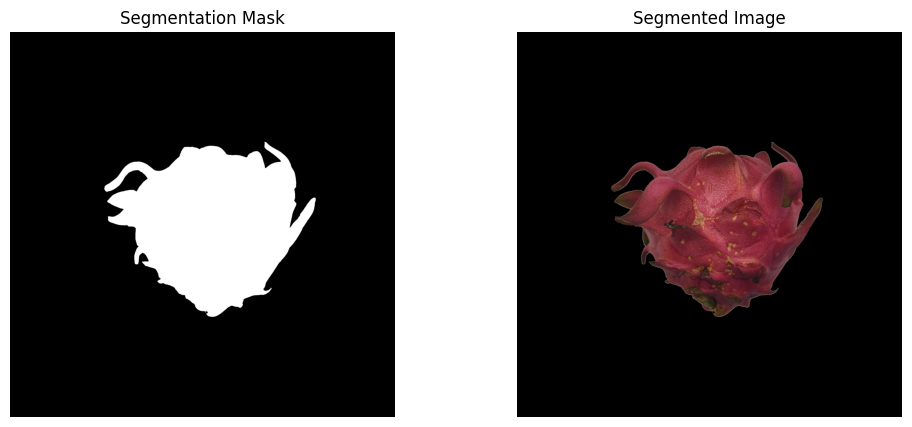

In [28]:
segmented, mask = segment_image(hsv)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].imshow(mask, cmap='gray')
axes[0].set_title("Segmentation Mask")
axes[0].axis("off")

axes[1].imshow(cv2.cvtColor(segmented, cv2.COLOR_HSV2RGB))
axes[1].set_title("Segmented Image")
axes[1].axis("off")

plt.show()

## Ekstraksi Fitur

In [29]:
def extract_features(segmented_img, mask):

    if mask is None or np.count_nonzero(mask) == 0:
        return 0.0, 0.0, 0.0, 0.0

    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return 0.0, 0.0, 0.0, 0.0

    c = max(contours, key=cv2.contourArea)
    x, y, w_box, h_box = cv2.boundingRect(c)

    pixel_per_cm = 102.0
    cm_per_pixel = 1.0 / pixel_per_cm

    length_cm = max(w_box, h_box) * cm_per_pixel * 0.9
    diameter_cm = min(w_box, h_box) * cm_per_pixel * 0.9

    ratio = length_cm / diameter_cm if diameter_cm > 0 else 0.0

    radius = diameter_cm / 2
    volume_cm3 = math.pi * (radius ** 2) * length_cm

    density = 0.22
    weight_est_g = density * volume_cm3
    weight_est_g *= 1.32

    return (
        round(length_cm, 3),
        round(diameter_cm, 3),
        round(weight_est_g, 3),
        round(ratio, 4)
    )


OUTPUT EKSTRAKSI FITUR

In [30]:
length, diameter, weight, ratio = extract_features(segmented, mask)

print("=== HASIL EKSTRAKSI FITUR ===")
print(f"Panjang (cm)   : {length}")
print(f"Diameter (cm)  : {diameter}")
print(f"Berat (g)      : {weight}")
print(f"Rasio L/D      : {ratio}")


=== HASIL EKSTRAKSI FITUR ===
Panjang (cm)   : 14.832
Diameter (cm)  : 12.274
Berat (g)      : 509.607
Rasio L/D      : 1.2085
